In [1]:
from occultence import *
import time

In [2]:
def binning(x, y, bins, error=None, std=False, mean_method=np.mean,
            mean_error_method=lambda x: np.sqrt(np.sum(np.power(x, 2))) / len(x)):

    bins = np.arange(np.min(x), np.max(x), bins)
    d = np.digitize(x, bins)

    final_bins = []
    binned_flux = []
    binned_error = []
    _std = []

    for i in range(1, np.max(d) + 1):
        s = np.where(d == i)
        if len(s[0]) > 0:
            binned_flux.append(mean_method(y[s[0]]))
            final_bins.append(np.mean(x[s[0]]))
            _std.append(np.std(y[s[0]]) / np.sqrt(len(s[0])))
            if error is not None:
                binned_error.append(mean_error_method(error[s[0]]))

    if std:
        return np.array(final_bins), np.array(binned_flux), np.array(_std)
    elif error is not None and isinstance(error, (np.ndarray, list)):
        return np.array(final_bins), np.array(binned_flux), np.array(binned_error)
    else:
        return np.array(final_bins), np.array(binned_flux)

nr of measurements: 9372
nr of measurements after binning: 1576


(0.98, 1.02)

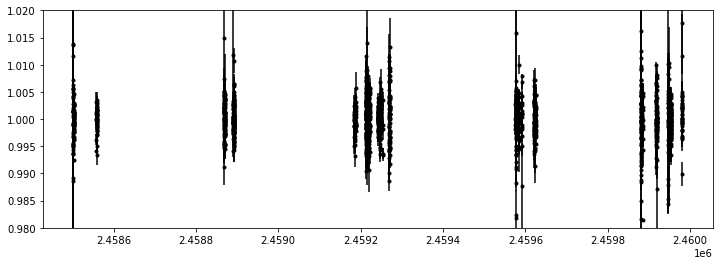

In [3]:
test_case = False
pre_bin = True


if test_case:

    t = np.linspace(0.5,0.9,200)
    ferr = 1e-3 * np.ones(len(t))
    f = 1 + (ferr * (np.random.randn(len(t))))
    f[22] = 1.01 # add a cosmic
    f[63] = 1.008 # add a cosmic
    f[50] = 0.0 # add a zero flux point
    # f[100:120] *= 0.995 # add a transit
    f *= np.linspace(1,1.01, len(t)) # add a linear trend for the GP to remove
    
else:
    file_path = "/Users/fl386/Desktop/SPECULOOS_project/zooniverse/data"
    files = glob.glob(file_path+"/*")

    i = 10
    file_name = files[i]
    gaia_id = file_name.split("/")[-1].replace(".csv","")

    data = pd.read_csv(file_name)

    mask = (~np.isnan(data["diff_flux_use"])) & (~np.isnan(data["diff_error"])) & (data["diff_error"]>0)
    data = data[mask]
    data.reset_index(drop = True, inplace = True)

    t = data["bjd"].values
    f = data["diff_flux_use"].values
    ferr = data["diff_error"].values
    print(f"nr of measurements: {len(t)}")
    if pre_bin:
        blc = binning(t, f, bins=0.005, error=ferr, std=True)
        t,f,ferr = blc
        print(f"nr of measurements after binning: {len(t)}")

    
    #just here:
    #t = t.min() + np.median(t[1:]-t[:-1])*np.arange(len(t))
    
plt.figure(figsize=(12,4))
plt.errorbar(t,f,ferr,fmt='k.')
plt.ylim(0.98,1.02)

In [4]:
targ = LightCurve(name = "test",
                  time = t,
                  flux = f,
                  uncertainty = np.abs(ferr),
                  metadata={'R_star':0.1*u.R_sun, 'M_star':0.1*u.M_sun})

In [5]:
targ_with_transit = targ.inject_transit(per=5*u.d, epoch=0.7 * u.d, inc=90 * u.degree, rp=1 * u.R_earth, ld=[0.3,0.3])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: xlabel='Time [d]', ylabel='Flux'>

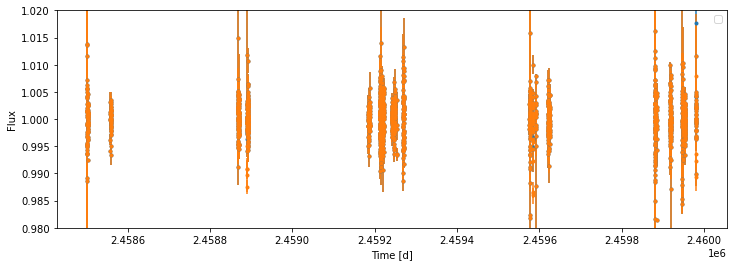

In [6]:
ax=targ.plot()
targ_with_transit.plot(ax=ax)

In [7]:
targ_with_transit.metadata

{'name': 'test_inject',
 'target': 'test',
 'R_star': <Quantity 0.1 solRad>,
 'M_star': <Quantity 0.1 solMass>,
 'injected_planet': {'period': [<Quantity 5. d>],
  'epoch': [<Quantity 0.7 d>],
  'inc': [<Quantity 90. deg>],
  'rp': [<Quantity 1. earthRad>],
  'a': [<Quantity 5.71151244 solRad>],
  'a_Rs': [<Quantity 57.11512439>],
  'ld': [[0.3, 0.3]],
  'depth': [<Quantity 0.00840502>],
  'duration': [<Quantity 0.03042218 d>]}}

In [8]:
planets = targ_with_transit.create_lots_of_transit_params(nfake=100, 
                                                          minimum_planet_radius=1 * u.R_earth, maximum_planet_radius=3 * u.R_earth,
                                                          minimum_period=0.5 * u.d, maximum_period=4 * u.d,)

In [9]:
planets

,logP,phase,cosi,r_p,depth,duration,epoch,a,a_Rs,recovered,...,rec_depth,rec_duration,rec_epoch,run,snr,target,r_s,m_s,teff,spt
0,0.582095,0.820037,0.000088,2.285344,0.043897688451897385,0.030815,2.458506e+06,4.773470050958038 solRad,47.734700509580385,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
1,0.412553,0.562567,0.000622,1.564536,0.02057357106477962,0.025574,2.458504e+06,3.6796513193945497 solRad,36.79651319394549,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
2,0.489520,0.172123,0.000323,1.136384,0.010853979603330436,0.026201,2.458503e+06,4.1411208804551665 solRad,41.41120880455166,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
3,0.309384,0.018643,0.000653,1.865569,0.029252372849054638,0.024200,2.458503e+06,3.14070717097885 solRad,31.4070717097885,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
4,0.261604,0.176669,0.002608,2.068496,0.03596233963131136,0.023655,2.458503e+06,2.9185962770055944 solRad,29.18596277005594,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.595225,0.290311,0.000082,1.870487,0.029406807286057355,0.030148,2.458504e+06,4.870662681701168 solRad,48.706626817011674,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
96,-0.057540,0.532382,0.002307,2.903120,0.0708383957714913,0.019748,2.458503e+06,1.7881804266381582 solRad,17.881804266381582,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
97,0.467282,0.658043,0.000471,1.448253,0.017629004174314556,0.026423,2.458504e+06,4.00214210449325 solRad,40.021421044932495,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None
98,0.326214,0.520138,0.000800,2.155368,0.03904645321966253,0.025069,2.458504e+06,3.222902989184992 solRad,32.22902989184992,0.0,...,0.0,0.0,0.0,0.0,0.0,test_inject,0.1 solRad,0.1 solMass,None,None


In [10]:
time_start = time.time()
lcs, lcs_clean, lcs_gp, lcs_bls, planets_df = targ.full_injection_recovery(nfake=1, pool=False, minimum_planet_radius=1 * u.R_earth, maximum_planet_radius=4 * u.R_earth,
                                       minimum_period=0.5 * u.d, maximum_period=4 * u.d, recovery_kw = {'condition_on_epoch':1 * u.hour}, 
                                       verbose=False)
print(int(time.time()-time_start),"seconds")

3 seconds


In [ ]:
import cProfile
cProfile.run('targ.full_injection_recovery(nfake=1, pool=False, minimum_planet_radius=1 * u.R_earth, maximum_planet_radius=4 * u.R_earth,minimum_period=0.5 * u.d, maximum_period=4 * u.d, recovery_kw = {"condition_on_epoch":1 * u.hour}, verbose=False)',sort="cumtime")

In [10]:
planets_df

,logP,phase,cosi,r_p,depth,duration,epoch,a,a_Rs,recovered,...,rec_depth,rec_duration,rec_epoch,run,snr,target,r_s,m_s,teff,spt
0,0.222567,0.917398,0.001236,1.730222,0.025161830987586096,0.022395,2.458504e+06,2.748836202811285 solRad,27.488362028112846,1.0,...,0.024599,0.02,2.459219e+06,0.0,10.525889,test,0.1 solRad,0.1 solMass,None,None


In [11]:
#planets_df.loc[0]

In [12]:
lcs[0].metadata, lcs_bls[0].metadata

({'name': 'test_inject0',
  'target': 'test',
  'R_star': <Quantity 0.1 solRad>,
  'M_star': <Quantity 0.1 solMass>,
  'injected_planet': {'period': [<Quantity 2.44030583 d>],
   'epoch': [<Quantity 2458504.33876103 d>],
   'inc': [<Quantity 1.57059076 rad>],
   'rp': [<Quantity 3.5076038 earthRad>],
   'a': [<Quantity 3.54052199 solRad>],
   'a_Rs': [<Quantity 35.40521987>],
   'ld': [[0.385, 0.304]],
   'depth': [<Quantity 0.10340933>],
   'duration': [<Quantity 0.02900098 d>]},
  'thresholds': {}},
 {'name': 'test_inject0_clean_bin_bls',
  'target': 'test',
  'R_star': <Quantity 0.1 solRad>,
  'M_star': <Quantity 0.1 solMass>,
  'injected_planet': {'period': [<Quantity 2.44030583 d>],
   'epoch': [<Quantity 2458504.33876103 d>],
   'inc': [<Quantity 1.57059076 rad>],
   'rp': [<Quantity 3.5076038 earthRad>],
   'a': [<Quantity 3.54052199 solRad>],
   'a_Rs': [<Quantity 35.40521987>],
   'ld': [[0.385, 0.304]],
   'depth': [<Quantity 0.10340933>],
   'duration': [<Quantity 0.02900098

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


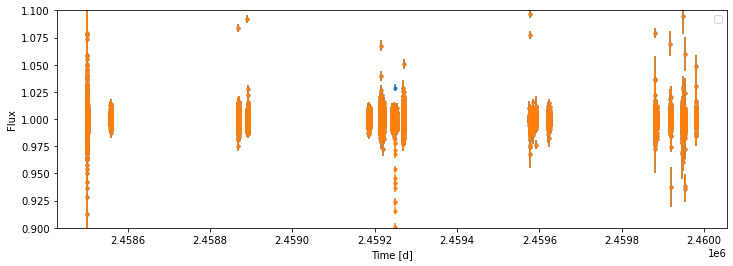

In [16]:
ax=targ.plot()
for i, lc in enumerate(lcs):
    #lc.plot(ax=ax, label=i, ylims=[0.9,1.1])
    lc.plot(ax=ax, ylims=[0.9,1.1])
    break

plt.legend()

For whatever reason the pooling doesn't seem to work in Jupyter on my computer...?

In [14]:
# pool = mp.Pool(5)
# lcs = pool.starmap(inject_transit, [(targ, (10**logp) * u.d, phase * 10**logp * u.d, math.acos(cosi) * u.radian,
#                                               rp * u.R_earth, [0.1,0.1]) for
#                                              logp, phase, cosi, rp in zip(planets['logP'], planets['phase'], planets['cosi'],
#                                                                           planets['r_p'])])

Text(0.5, 0, 'Planet Radius [R_earth]')

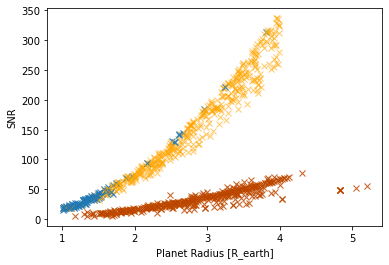

In [18]:
n_points_in_transit = planets_df['duration']/(7.5/(24*60))
lc_noise = 1e-3
rec_r_p = [x.to_value("R_earth") for x in (np.sqrt(planets_df['rec_depth']) * planets_df['r_s']).values]

for r_p, depth, rec, r_p_rec, snr, n in zip(planets_df['r_p'], planets_df['depth'],  planets_df['recovered'],rec_r_p,  planets_df['snr'], n_points_in_transit):
    if rec == 1.0:
        color = "orange"
    else:
        color = "C0"
        
    if r_p_rec == 0.0:
        r_p_rec = r_p
        snr = depth * np.sqrt(n)/lc_noise
    plt.plot([r_p,r_p_rec], [depth * np.sqrt(n)/lc_noise, snr], 'x', color=color, alpha=0.6)
    if rec == 1.0:
        plt.plot([r_p_rec], [snr], 'x', color='darkred', alpha=0.5)
plt.ylabel("SNR")
plt.xlabel("Planet Radius [R_earth]")
# plot_transitparams(results[4]['r_p'], results[4]['depth'] * np.sqrt(n_points_in_transit)/lc_noise, results[4]['recovered'], xlabel="Radius", ylabel="SNR", zlabel="Detected?", ylims=[], yscale='uniform',
#                        xscale='uniform', add_points={}, svname="")

Print recovery stats:

In [19]:
print(f"Planets recovered: {100 * len(planets_df.loc[planets_df['recovered'] == 1.0]) /  len(planets_df['recovered'])}%")
print(f"Observed Planets recovered: {100 * len(planets_df.loc[(planets_df['recovered'] == 1.0) & (planets_df['observed'] == 1.0)]) /  len(planets_df['recovered'][planets_df['observed']==1.0])}%")

Planets recovered: 79.6%
Observed Planets recovered: 100.0%


Plot only the planets which were observed:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


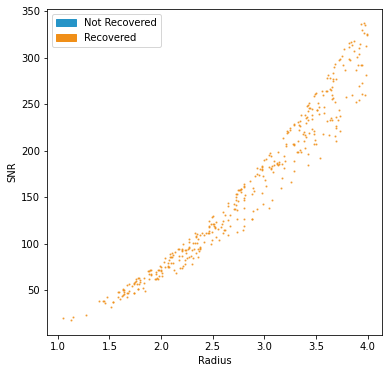

In [20]:
plot_transitparams(planets_df['r_p'][planets_df['observed'] == 1.0], planets_df['depth'][planets_df['observed'] == 1.0] * np.sqrt(n_points_in_transit[planets_df['observed'] == 1.0])/lc_noise, planets_df['recovered'][planets_df['observed'] == 1.0], xlabel="Radius", ylabel="SNR", zlabel="Detected?", ylims=[], yscale='uniform',
                       xscale='uniform', add_points={}, svname="")

Text(0, 0.5, 'Radius [R_Earth]')

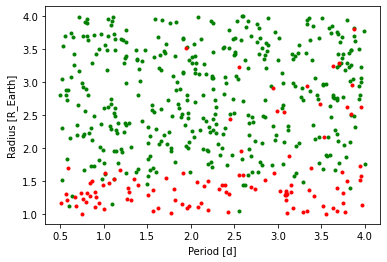

In [28]:
per = 10**planets_df['logP']
rad = planets_df['r_p']

plt.plot(per[planets_df['observed'] == 1.0],rad[planets_df['observed'] == 1.0],".",color="green")
plt.plot(per[planets_df['observed'] == 0.0],rad[planets_df['observed'] == 0.0],".",color="red")

plt.xlabel("Period [d]")
plt.ylabel("Radius [R_Earth]")